# Rectified Flow Inference

Load a checkpoint and sample using `rectified_flow_sample`.

In [1]:
from pathlib import Path
import sys
import random

import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.io import loadmat
import os 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "5"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

project_root = Path.cwd()
if project_root.name == 'visualize':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Clear Jupyter's argv to avoid argparse conflicts
if hasattr(sys, 'argv'):
    original_argv = sys.argv.copy()
    sys.argv = [sys.argv[0]]


from datawrapper.datawrapper import _coerce_matlab_text, _normalize_tensor
from datawrapper.simple_tokenizer import SimpleTokenizer
from datawrapper.warpper_utils import interpolate_to_target_width, resize_512
from model.listfm_it import load_from_ckpt
from core_funcs import rectified_flow_sample
from common.metric import calculate_psnr, calculate_ssim

# Import Qwen tokenizer for LLM instruction encoding
from transformers import AutoTokenizer

tokenizer = SimpleTokenizer()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Initialize Qwen tokenizer
qwen_model_path = "/home/intern4/.cache/huggingface/hub/models--Qwen--Qwen2.5-0.5B-Instruct/snapshots/7ae557604adf67be50417f59c2c2f167def9a775"
# qwen_model_path = "/home/intern4/.cache/huggingface/hub/models--Qwen--Qwen2.5-3B-Instruct/snapshots/aa8e72537993ba99e69dfaafa59ed015b17504d1"
qwen_tokenizer = AutoTokenizer.from_pretrained(qwen_model_path, use_fast=True)
print("Qwen tokenizer loaded")


device: cuda:0


In [2]:
run_idx = 74
run_ep = 20

# use best checkpoint for now
# ckpt_path = Path(f"/home/intern2/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/checkpoints/checkpoint_best.ckpt")
ckpt_path = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/checkpoints/checkpoint_{run_ep}.ckpt")
data_root = Path("/fast_storage/intern/data/instruction_tuning/brats_acceleration_crossmodal_mat")
# sample_path = data_root / "val"
sample_path = data_root

# Load model with Qwen LLM support
qwen_lora_path = "/home/intern4/fm2026/mrfm-intern/code_it_llm_ca/dapt/outputs/lora-0.5B/checkpoint-606"
model = load_from_ckpt(
    ckpt_path=ckpt_path, 
    from_scratch=False, 
    use_vision_decoder=True, 
    use_vision_decoder_weights=True,
    qwen_model_path=qwen_model_path,
    qwen_lora_path=qwen_lora_path,
    qwen_trainable=False,
    qwen_dtype="bf16"
)
model = model.to(device)
model.eval()
print("loaded", ckpt_path)
print("with Qwen LLM instruction encoder")


2026-02-04 21:15:47 [SUCCESS] Checkpoint loaded successfully.
2026-02-04 21:15:47 [DEBUG] Width check success
2026-02-04 21:15:47 [DEBUG] Head check success
2026-02-04 21:15:47 [DEBUG] BPE file exists.
2026-02-04 21:15:49 [DEBUG] QC start.
2026-02-04 21:15:49 [DEBUG] Image size: torch.Size([2, 1, 512, 512])
2026-02-04 21:15:49 [DEBUG] Text size: torch.Size([2, 1536])
2026-02-04 21:15:55 [DEBUG] img_full_feature size: torch.Size([2, 1025, 512])
2026-02-04 21:15:55 [DEBUG] text_full_feature size: torch.Size([2, 1536, 512])
2026-02-04 21:15:55 [DEBUG] img mean std max min: 0.0655 0.9935 7.4361 -4.1694
2026-02-04 21:15:55 [DEBUG] text mean std max min: 0.0451 1.0481 3.4132 -18.1809
2026-02-04 21:15:55 [DEBUG] stack_feature[0] size: torch.Size([2, 64, 512, 512])
2026-02-04 21:15:55 [DEBUG] stack_feature[1] size: torch.Size([2, 128, 256, 256])
2026-02-04 21:15:55 [DEBUG] stack_feature[2] size: torch.Size([2, 256, 128, 128])
2026-02-04 21:15:55 [DEBUG] stack_feature[3] size: torch.Size([2, 51

In [3]:
# Pick one sample
files = sorted(sample_path.glob("*.mat"))
assert files, f"no .mat files in {sample_path}"
mat_path = random.choice(files)
# mat_path = files[10]
data = loadmat(mat_path)

img = torch.from_numpy(data["image"]).unsqueeze(0).unsqueeze(0).float()
label = torch.from_numpy(data["label"]).unsqueeze(0).unsqueeze(0).float()

img = interpolate_to_target_width(img, target_size=512)
img = resize_512(img)
label = resize_512(interpolate_to_target_width(label, target_size=512))

img = _normalize_tensor(img)
label = _normalize_tensor(label)

text_raw = _coerce_matlab_text(data["text"][0][0])
# instr_raw = _coerce_matlab_text(data["instruction"][0][0])
instr_raw = "Reconstruct this mri image"

text = tokenizer.tokenize(text_raw, context_length=1536).squeeze().unsqueeze(0)
instruction = tokenizer.tokenize(instr_raw, context_length=64).squeeze().unsqueeze(0)

# Tokenize instruction with Qwen LLM
llm_inputs = qwen_tokenizer(
    instr_raw,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt",
)
instruction_llm_ids = llm_inputs["input_ids"].squeeze(0)
instruction_llm_mask = llm_inputs["attention_mask"].squeeze(0)

img = img.to(device)
label = label.to(device)
text = text.to(device)
instruction = instruction.to(device)
instruction_llm_ids = instruction_llm_ids.to(device).unsqueeze(0)
instruction_llm_mask = instruction_llm_mask.to(device).unsqueeze(0)
label_2 = label.clone()
label_exp = label.clone()

print("sample", mat_path.name)
# print("text:", text_raw)
print("instruction:", instr_raw)


sample brats_01606_t1_R2_to_t1ce_s119_000059.mat
instruction: Use this accelerated T1 MRI slice (R=2) to produce a clean T1CE slice.


In [4]:
with torch.no_grad():
    out = rectified_flow_sample(
        model=model, 
        img=img, 
        text=text, 
        instruction=instruction,
        instruction_llm_ids=instruction_llm_ids,
        instruction_llm_mask=instruction_llm_mask
    )
    # out_oneshot = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction, steps=1)

print("out shape:", tuple(out.shape))
print("label shape:", tuple(label.shape))


out shape: (1, 1, 512, 512)
label shape: (1, 1, 512, 512)


In [5]:
# Metric check (PSNR, SSIM, MSE)
psnr = calculate_psnr(label, out)
ssim = calculate_ssim(label, out)
print("psnr:", psnr.item())
print("ssim:", ssim.item())

# psnr_oneshot = calculate_psnr(label, out_oneshot)
# ssim_oneshot = calculate_ssim(label, out_oneshot)
# print("oneshot psnr:", psnr_oneshot.item())
# print("oneshot ssim:", ssim_oneshot.item())

mse = torch.mean((out.detach().cpu() - label.detach().cpu()) ** 2).item()
print("mse:", mse)
# mse_oneshot = torch.mean((out_oneshot.detach().cpu() - label.detach().cpu()) ** 2).item()
# print("oneshot mse:", mse_oneshot)


psnr: 19.67615509033203
ssim: 0.7496930360794067
mse: 0.08650639653205872


input: (-0.4391099, 3.2289817, 2.7939677e-08, 0.99999994)
out: (-0.7448881, 2.833572, -0.0028812345, 0.9616126)
label: (-0.38199878, 8.558379, 9.313226e-09, 1.0)


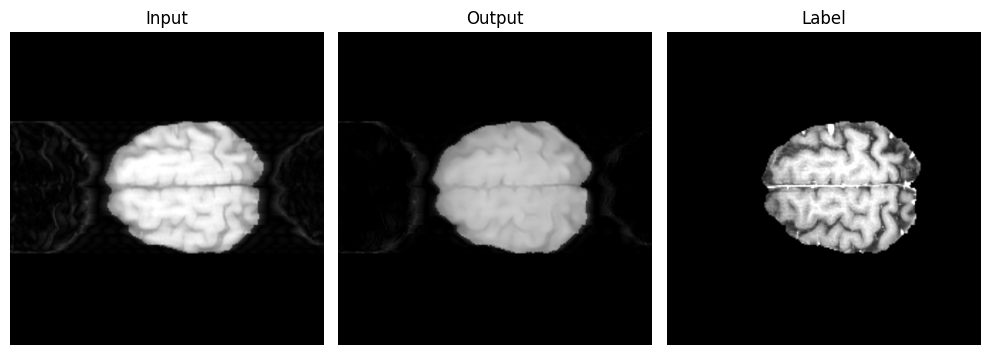

In [6]:
# plot input, output, label
input = img.squeeze().detach().cpu().numpy()
out = out.squeeze().detach().cpu().numpy()
label = label.squeeze().detach().cpu().numpy()
# out_oneshot = out_oneshot.squeeze().detach().cpu().numpy()

x1, x2, y1, y2 = 20, -20, 20, -20


print(f"input: {input.min(), input.max(), input.mean(), input.std()}")
print(f"out: {out.min(), out.max(), out.mean(), out.std()}")
print(f"label: {label.min(), label.max(), label.mean(), label.std()}")

vmin_input = np.percentile(input, 0.5)
vmax_input = np.percentile(input, 99.5)
vmin_out = np.percentile(label, 0.5)
vmax_out = np.percentile(label, 99.5)


plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(out[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(label[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Label")
plt.axis("off")

plt.tight_layout()
plt.show()

In [17]:
# Inference All and Save as .mat
import json
from tqdm import tqdm
from scipy.io import savemat

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2,3,4,5"

import torch
device = torch.device("cuda:0")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_idx = 74
run_ep = 20

# Create output directory
output_dir = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/inference/ep_{run_ep}")
output_dir.mkdir(parents=True, exist_ok=True)

files = sorted(sample_path.glob("*.mat"))
assert files, f"no .mat files in {sample_path}"
files = files[:10]

print(f"Processing {len(files)} samples...")
print(f"Output directory: {output_dir}")

results = []
model.eval()

with torch.no_grad():
    for idx, mat_path in enumerate(tqdm(files)):
        try:
            data = loadmat(mat_path)
            
            img = torch.from_numpy(data["image"]).unsqueeze(0).unsqueeze(0).float()
            label = torch.from_numpy(data["label"]).unsqueeze(0).unsqueeze(0).float()
            
            img = interpolate_to_target_width(img, target_size=512)
            img = resize_512(img)
            label = resize_512(interpolate_to_target_width(label, target_size=512))
            
            img = _normalize_tensor(img)
            label = _normalize_tensor(label)
            
            text_raw = _coerce_matlab_text(data["text"][0][0])
            instr_raw = _coerce_matlab_text(data["instruction"][0][0])
            
            text = tokenizer.tokenize(text_raw, context_length=1536).squeeze().unsqueeze(0)
            instruction = tokenizer.tokenize(instr_raw, context_length=64).squeeze().unsqueeze(0)
            
            # Tokenize instruction with Qwen LLM
            llm_inputs = qwen_tokenizer(
                instr_raw,
                padding="max_length",
                truncation=True,
                max_length=128,
                return_tensors="pt",
            )
            instruction_llm_ids = llm_inputs["input_ids"].squeeze(0)
            instruction_llm_mask = llm_inputs["attention_mask"].squeeze(0)
            
            img = img.to(device)
            label = label.to(device)
            text = text.to(device)
            instruction = instruction.to(device)
            instruction_llm_ids = instruction_llm_ids.to(device).unsqueeze(0)
            instruction_llm_mask = instruction_llm_mask.to(device).unsqueeze(0)
            
            # Inference with LLM
            out = rectified_flow_sample(
                model=model, 
                img=img, 
                text=text, 
                instruction=instruction,
                instruction_llm_ids=instruction_llm_ids,
                instruction_llm_mask=instruction_llm_mask
            )
            
            # Calculate metrics
            psnr = calculate_psnr(label, out)
            ssim = calculate_ssim(label, out)
            mse = torch.mean((out.detach().cpu() - label.detach().cpu()) ** 2)
            
            # Convert to numpy
            img_np = img.squeeze().detach().cpu().numpy()
            out_np = out.squeeze().detach().cpu().numpy()
            label_np = label.squeeze().detach().cpu().numpy()
            
            # Save as .mat file
            out_mat_path = output_dir / f"{mat_path.stem}_result.mat"
            savemat(str(out_mat_path), {
                'input': img_np,
                'out': out_np,
                'label': label_np,
                'instruction': instr_raw,
                'psnr': psnr.item(),
                'ssim': ssim.item(),
                'mse': mse.item()
            })
            
            # Store metrics
            result = {
                "filename": mat_path.name,
                "stem": mat_path.stem,
                "psnr": psnr.item(),
                "ssim": ssim.item(),
                "mse": mse.item(),
                "instruction": instr_raw
            }
            results.append(result)
            
        except Exception as e:
            print(f"Error processing {mat_path.name}: {e}")
            continue

# Save summary metrics to JSON
summary = {
    "total_samples": len(results),
    "mean_psnr": np.mean([r["psnr"] for r in results]),
    "mean_ssim": np.mean([r["ssim"] for r in results]),
    "mean_mse": np.mean([r["mse"] for r in results]),
    "std_psnr": np.std([r["psnr"] for r in results]),
    "std_ssim": np.std([r["ssim"] for r in results]),
    "std_mse": np.std([r["mse"] for r in results]),
    "run_idx": run_idx,
    "run_ep": run_ep,
}

summary_path = output_dir / "summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

# Save detailed results
results_path = output_dir / "detailed_results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nInference complete!")
print(f"Mean PSNR: {summary['mean_psnr']:.2f} +/- {summary['std_psnr']:.2f}")
print(f"Mean SSIM: {summary['mean_ssim']:.4f} +/- {summary['std_ssim']:.4f}")
print(f"Mean MSE: {summary['mean_mse']:.6f} +/- {summary['std_mse']:.6f}")
print(f"Results saved to: {output_dir}")


Processing 10 samples...
Output directory: /home/intern4/fm2026/fm_flow/code_it/logs/00074_train/inference/ep_20


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:44<00:00, 10.45s/it]


Inference complete!
Mean PSNR: 23.16 +/- 5.59
Mean SSIM: 0.5511 +/- 0.2835
Mean MSE: 0.290135 +/- 0.183059
Results saved to: /home/intern4/fm2026/fm_flow/code_it/logs/00074_train/inference/ep_20


In [19]:
log_root = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/inference/ep_{run_ep}")
res_files = sorted(log_root.glob("*_result.mat"))
print(f"Found {len(res_files)} result files")

Found 10 result files


In [20]:
idx = 0

In [ ]:
idx += 1
print(idx)

res_mat = loadmat(res_files[idx])
input_img = res_mat["input"].squeeze()
output_img = res_mat["out"].squeeze()
label_img = res_mat["label"].squeeze()
instruction = res_mat["instruction"]

x1, x2, y1, y2 = 20, -20, 20, -20

vmin_input = np.percentile(input_img, 0.5)
vmax_input = np.percentile(input_img, 99.5)
vmin_out = np.percentile(output_img, 0.5)
vmax_out = np.percentile(output_img, 99.5)
vmin_label = np.percentile(label_img, 0.5)
vmax_label = np.percentile(label_img, 99.5)

plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.imshow(input_img[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(output_img[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(label_img[x1:x2, y1:y2], cmap="gray", vmin=vmin_label, vmax=vmax_label)
plt.title("Label")
plt.axis("off")
plt.subplot(1, 4, 4)
diff = np.abs(output_img[x1:x2, y1:y2] - label_img[x1:x2, y1:y2])
print(output_img.shape, input_img.shape, diff.shape)
plt.imshow(diff, cmap="hot")
plt.colorbar()
plt.title("Output-Label Difference")
plt.axis("off")

plt.tight_layout()
plt.show()

10


IndexError: list index out of range

: 

In [ ]:
label_exp_temp = label_exp.clone()

# Experiment: tweak steps and time scheduling
def make_t_schedule(steps, schedule="linear", device=None):
    if schedule == "linear":
        t_vals = torch.linspace(0.0, 1.0, steps + 1, device=device)
    elif schedule == "cosine":
        s = torch.linspace(0.0, 1.0, steps + 1, device=device)
        t_vals = 0.5 - 0.5 * torch.cos(torch.pi * s)
    elif schedule == "sigmoid":
        s = torch.linspace(-4.0, 4.0, steps + 1, device=device)
        t_vals = torch.sigmoid(s)
    else:
        raise ValueError(f"unknown schedule: {schedule}")
    return t_vals

def rectified_flow_sample_sched(model, img, text, instruction, instruction_llm_ids, instruction_llm_mask, steps=10, schedule="linear", t_eps=1e-4):
    t_vals = make_t_schedule(steps, schedule=schedule, device=img.device)
    z = torch.randn_like(img)
    for i in range(steps):
        t = t_vals[i].view(1, 1, 1, 1).expand(img.shape[0], 1, 1, 1)
        t_next = t_vals[i + 1].view(1, 1, 1, 1).expand(img.shape[0], 1, 1, 1)
        x_pred = model.forward(
            img=img,
            text=text,
            use_bottleneck=True,
            grad_encoder=True,
            instruction=instruction,
            instruction_llm_ids=instruction_llm_ids,
            instruction_llm_mask=instruction_llm_mask,
            flow_xt=z,
            flow_t=t.view(img.shape[0], 1),
        )
        denom = (1.0 - t).clamp_min(t_eps)
        v_pred = (x_pred - z) / denom
        z = z + (t_next - t) * v_pred
    return z

steps = 10
schedule = "linear"  # linear | cosine | sigmoid
t_eps = 1e-4

with torch.no_grad():
    out_exp = rectified_flow_sample_sched(
        model, img, text, instruction, 
        instruction_llm_ids, instruction_llm_mask,
        steps=steps, schedule=schedule, t_eps=t_eps
    )

print("steps", steps, "schedule", schedule, "t_eps", t_eps)
print("out shape:", tuple(out_exp.shape))
print("out mse: ", torch.mean((out_exp.detach().cpu() - label_exp_temp.detach().cpu()) ** 2).item())


steps 10 schedule linear t_eps 0.0001
out shape: (1, 1, 512, 512)
out mse:  0.022062458097934723


In [ ]:
# for steps in [10, 20, 40]:
#     for schedule in ["linear", "cosine", "sigmoid"]:
#         t_eps = 1e-4

#         with torch.no_grad():
#             out_exp = rectified_flow_sample_sched(model, img, text, instruction, steps=steps, schedule=schedule, t_eps=t_eps)
        
#         print("steps", steps, "schedule", schedule, "t_eps", t_eps)
#         print("out mse: ", torch.mean((out_exp.detach().cpu() - label_exp_temp.detach().cpu()) ** 2).item())

In [ ]:
# # Full-step vs one-shot metrics on test split
# test_root = data_root / "test"
# test_files = sorted(test_root.glob("*.mat"))
# if len(test_files) > 100:
#     test_files = test_files[:100] # limit to 100 samples for quicker testing
# print("test files:", len(test_files))

# full_steps = None  # None uses rectified_flow_sample default
# max_samples = None  # set to an int to limit runtime
# psnr_full_vals = []
# ssim_full_vals = []
# mse_full_vals = []
# psnr_one_vals = []
# ssim_one_vals = []
# mse_one_vals = []

# model.eval()
# with torch.no_grad():
#     for idx, mat_path in enumerate(test_files):
#         if max_samples is not None and idx >= max_samples:
#             break
#         data = loadmat(mat_path)

#         img = torch.from_numpy(data["image"]).unsqueeze(0).unsqueeze(0).float()
#         label = torch.from_numpy(data["label"]).unsqueeze(0).unsqueeze(0).float()

#         img = interpolate_to_target_width(img, target_size=512)
#         img = resize_512(img)
#         label = resize_512(interpolate_to_target_width(label, target_size=512))

#         img = _normalize_tensor(img)
#         label = _normalize_tensor(label)

#         text_raw = _coerce_matlab_text(data["text"][0][0])
#         instr_raw = _coerce_matlab_text(data["instruction"][0][0])

#         text = tokenizer.tokenize(text_raw, context_length=1536).squeeze().unsqueeze(0)
#         instruction = tokenizer.tokenize(instr_raw, context_length=1536).squeeze().unsqueeze(0)

#         img = img.to(device)
#         label = label.to(device)
#         text = text.to(device)
#         instruction = instruction.to(device)

#         if full_steps is None:
#             out_full = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction)
#         else:
#             out_full = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction, steps=full_steps)
#         out_oneshot = rectified_flow_sample(model=model, img=img, text=text, instruction=instruction, steps=1)

#         psnr_full = calculate_psnr(out_full, label)
#         ssim_full = calculate_ssim(out_full, label)
#         mse_full = torch.mean((out_full - label) ** 2)

#         psnr_one = calculate_psnr(out_oneshot, label)
#         ssim_one = calculate_ssim(out_oneshot, label)
#         mse_one = torch.mean((out_oneshot - label) ** 2)

#         psnr_full_vals.append(psnr_full.item())
#         ssim_full_vals.append(ssim_full.item())
#         mse_full_vals.append(mse_full.item())
#         psnr_one_vals.append(psnr_one.item())
#         ssim_one_vals.append(ssim_one.item())
#         mse_one_vals.append(mse_one.item())

#         if (idx + 1) % 20 == 0:
#             print("processed", idx + 1)

# if psnr_full_vals:
#     print(f"full-step PSNR: {np.mean(psnr_full_vals):.2f} +/- {np.std(psnr_full_vals):.2f}")
#     print(f"one-shot PSNR: {np.mean(psnr_one_vals):.2f} +/- {np.std(psnr_one_vals):.2f}")
#     print(f"delta PSNR (full - one): {np.mean(np.array(psnr_full_vals) - np.array(psnr_one_vals)):.2f}")
#     print(f"full-step SSIM: {np.mean(ssim_full_vals):.4f} +/- {np.std(ssim_full_vals):.4f}")
#     print(f"one-shot SSIM: {np.mean(ssim_one_vals):.4f} +/- {np.std(ssim_one_vals):.4f}")
#     print(f"delta SSIM (full - one): {np.mean(np.array(ssim_full_vals) - np.array(ssim_one_vals)):.4f}")
#     print(f"full-step MSE: {np.mean(mse_full_vals):.6f} +/- {np.std(mse_full_vals):.6f}")
#     print(f"one-shot MSE: {np.mean(mse_one_vals):.6f} +/- {np.std(mse_one_vals):.6f}")
#     print(f"delta MSE (full - one): {np.mean(np.array(mse_full_vals) - np.array(mse_one_vals)):.6f}")
# else:
#     print("no test samples found in", test_root)
